# Markov Decision Process

A stationary discrete Markov Decision Process (MDP) is characterized by the tuple $(\mathcal{X},\mathcal{A},\mathbb{P},r,\gamma)$, where 

1. $\mathcal{X}$ is the (finite countable) set of states; 
2. $\mathcal{A}$ is the (finite countable) set of actions;
3. $P : \mathcal{X} \times \mathcal{A} \times \mathcal{X} \to [0,1]$ is the transition probability function, such that $P(x,a,x^+)$ is the probability of ending up in state $x^+ \in \mathcal{S}$ from state $x \in \mathcal{X}$ when taking action $a \in \mathcal{A}$;
4. $r : \mathcal{X} \times \mathcal{X} \to \mathbb{R}$ is the reward function, so that $r(x,x^+)$ returns the reward for 
transitioning from state $x \in \mathcal{X}$ to state $x^+ \in \mathcal{X}$;
5. $\gamma \in \mathbb{R}_{> 0}$ is a discount factor [1].

The aim is to find a policy, i.e., a function $\pi : \mathcal{S} \to \mathcal{A}$, returning the best action for any given state. A solution concept for MDP is the *value function*, $v^{\pi} : \mathcal{S} \to \mathbb{R}$, defined as
$$
\begin{equation}
    \label{eq:bellman}
    v^{\pi}(x) = \overbrace{\sum_{x^+ \in \mathcal{X}} P(x,\pi(x),x^+) \left( r(x,x^+) + \gamma v(x^+) \right)}^{=:\mathsf{T}(v^{\pi})}
\end{equation}
$$

returning the "goodness" of policy $\pi$. The expression in $\eqref{eq:bellman}$ is known as *Bellman equation*, and can be expressed as an operator of $v^{\pi}$, i.e., $\mathsf{T}[v^\pi(s)] =: \mathsf{T}(v^{\pi})$. It can be shown that the value function yielded by the optimal policy, $v^*$, results from the fixed-point problem $v^* = \mathsf{T}(v^*)$. Therefore, the latter can be formulated as a canonical VI, with $F = \mathsf{I} - \mathsf{T}$.

Let's start by defining the problem data

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from monviso import VI

np.random.seed(2024)

# Number of states and actions, discount factor
num_X, num_A = 20, 10
gamma = 0.8

# Transition probabilities and reward
P = np.random.rand(num_X, num_A, num_X)
P /= P.sum(2, keepdims=True)
R = np.random.rand(num_X, num_X)

Let's define the Bellman operator (as fixed point), the VI mapping, and the initial solution

In [2]:
T = lambda v: np.einsum("ijk,ik -> ij", P, R + gamma * v[None, :]).max(1)
F = lambda x: x - T(x)

mdp = VI(F)
x = np.random.rand(num_X)

As examples, we can use the forward-reflected-backward ([`frb`](../../api/#forward-reflected-backward)), the projected reflected gradient ([`prg`](../../api/#projected-reflected-gradient)), and the extra anchored gradient ([`eag`](../../api/#extra-anchored-gradient)).

In [3]:
max_iter = 300
step_size = 0.05

residuals_frb = np.zeros(max_iter)
residuals_prg = np.zeros(max_iter)
residuals_eag = np.zeros(max_iter)

# Copy the same initial solution for the three methods
xk_frb, x1k_frb = np.copy(x), np.copy(x)
xk_prg, x1k_prg = np.copy(x), np.copy(x)
xk_eag, x0_eag = np.copy(x), np.copy(x)

for k in range(max_iter):
    # Forward-reflected-backward
    xk1_frb = mdp.frb(xk_frb, x1k_frb, step_size)
    residuals_frb[k] = np.linalg.norm(xk1_frb - xk_frb)
    xk_frb, x1k_frb = xk1_frb, xk_frb

    # Projected reflected gradient
    xk1_prg = mdp.prg(xk_prg, x1k_prg, step_size)
    residuals_prg[k] = np.linalg.norm(xk1_prg - xk_prg)
    xk_prg = xk1_prg

    # Extra anchored gradient
    xk1_eag = mdp.eag(xk_eag, x0_eag, k, step_size)
    residuals_eag[k] = np.linalg.norm(xk1_eag - xk_eag)
    xk_eag = xk1_eag

The API docs have some detail on the [convention for naming iterative steps](../../api/#iterative-methods). Let's check out the residuals for each method. 

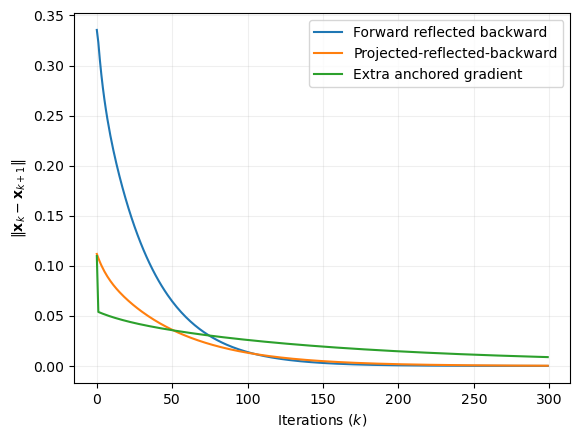

In [4]:
fig, ax = plt.subplots()

ax.plot(residuals_frb, label="Forward reflected backward")
ax.plot(residuals_prg, label="Projected-reflected-backward")
ax.plot(residuals_eag, label="Extra anchored gradient")

ax.grid(True, alpha=0.2)
ax.set_xlabel("Iterations ($k$)")
ax.set_ylabel(r"$\|\mathbf{x}_k - \mathbf{x}_{k+1}\|$")
plt.legend()

plt.savefig("fig/markov-decision-process.pdf")
plt.show()

## References
[1] Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.